# Completeness using the empirical Gaia DR3 selection function

Our selection function of the Gaia DR3 catalogue can be queried via a precomputed all-sky map, available in healpix resolution of order 7.

In [1]:
from gaiasf.selectionfunctions import DR3SelectionFunctionTCG_hpx7

When we call the class, the package will look for the file **allsky_M10_hpx7.hdf5**. If it is not present, it will download it.

In [2]:
dr3sf = DR3SelectionFunctionTCG_hpx7()

To obtain the completeness at a given point and magnitude we use the **.query()** method. The coordinates must be given as astropy objects. To quickly generate the list of coordinates of the centers of healpixels we provide the **get_healpix_centers** function. The array containing magnitudes must have the same shape as the coordinate array.

In [3]:
from gaiasf.utils import get_healpix_centers
coords_of_centers = get_healpix_centers(7)
import numpy as np
gmag = np.ones_like(coords_of_centers) * 21.
print(f'Computing the completeness for {len(coords_of_centers)} points.')
completeness = dr3sf.query(coords_of_centers,gmag)

Computing the completeness for 196608 points.


This returned an array of numbers between 0 and 1:

In [4]:
print(completeness)

[0.71134132 0.70507193 0.68480934 ... 0.67515502 0.72601739 0.65644743]


We can use healpy's **mollview** to plot the all-sky map. The healpix numbering scheme is in equatorial coordinates ('Celestial' in healpy), but for all-sky maps I prefer using Galactic coordinates:

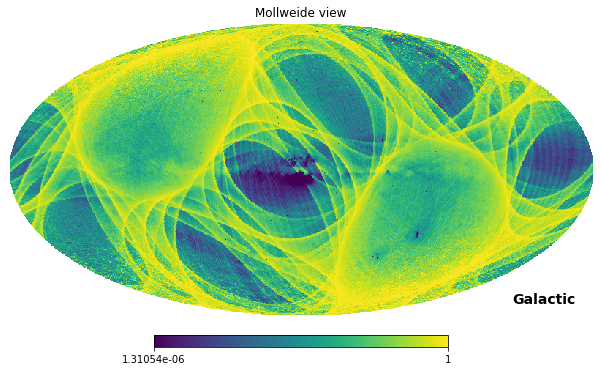

In [5]:
import healpy as hp
hp.mollview(completeness,coord=['Celestial','Galactic'])

You might recognise some features already. The stripes are caused by the Gaia scanning law. Regions with high stellar density are also visible, in the direction of the Galactic centre, or the Magellanic clouds. The presence of globular clusters is also visible, as individual healpixels of low completeness.

We can zoom in on a particular region with **gnomview**, for instance the globular cluster NGC 6752 near (ra,dec)=(288,-60).

To display a 2 degree x 2 degree field we make a plot with width of 240 pixels, and 0.5 arcminute per pixel.

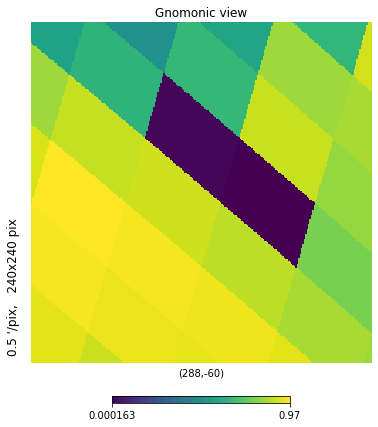

In [6]:
hp.gnomview(completeness,rot=[288,-60],xsize=240,reso=0.5)

The size of a healpix order 7 is about half a degree, which may be too coarse for some science cases.

## Creating a higher resolution map of a specific region

**This queries the Gaia archive using the astroquery package.**

We provide a way to initialise the model map for a small region of the sky (a few square degrees are still manageable). The map will employ healpixels of level 6 to 12, providing a finer resolution in the denser areas.

At present this only creates square patches, centered on a (ra,dec) position specified by the user, and edge width given in degrees:

        patch = DR3SelectionFunctionTCG_from_patch( ra , dec , size )

Querying the Gaia archive...
INFO: Query finished. [astroquery.utils.tap.core]
15182 sources downloaded.
Grouping the stars by hpx level 12...


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Grouping the stars by hpx level 11...
Grouping the stars by hpx level 10...
Grouping the stars by hpx level 9...
Grouping the stars by hpx level 8...
Done.


/opt/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:346: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1194: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1195: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


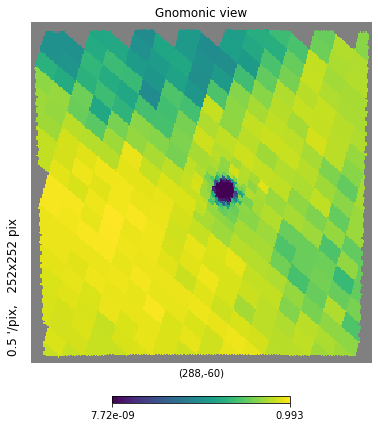

In [7]:
from gaiasf.selectionfunctions import DR3SelectionFunctionTCG_from_patch
patch = DR3SelectionFunctionTCG_from_patch(288,-60,2)
patch.display(G=21)

The completeness is evaluated from the median magnitude of sources with fewer than 10 matched transits. By default, the map requires at least 20 such sources per spatial bin. If we lower this requirement we can make higher-resolution (but noisier) maps:

Querying the Gaia archive...
INFO: Query finished. [astroquery.utils.tap.core]
15182 sources downloaded.
Grouping the stars by hpx level 12...


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Grouping the stars by hpx level 11...
Grouping the stars by hpx level 10...
Grouping the stars by hpx level 9...
Grouping the stars by hpx level 8...
Done.


/opt/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:346: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1194: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1195: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


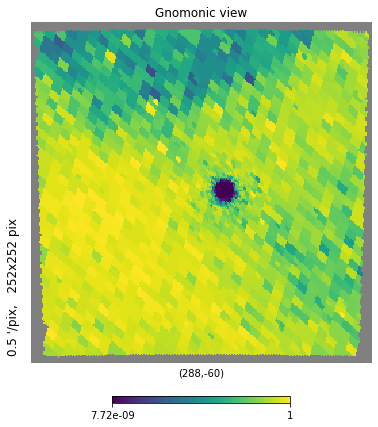

In [8]:
patch_higher_res = DR3SelectionFunctionTCG_from_patch(288,-60,2,min_points=5)
patch_higher_res.display(G=21)

We can also query the completeness at any position, provided it is contained inside the maps.

Here we evaluate the completeness at various magnitudes, along a straight line going through the globular cluster. 

Text(0, 0.5, 'completeness')

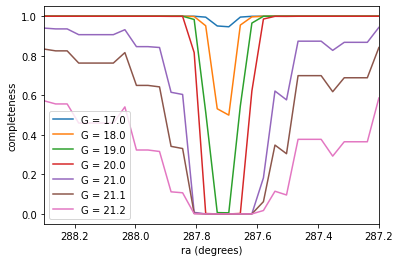

In [9]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

ra = np.linspace(287.2,288.3,30)
dec = -60 * np.ones_like(ra)

cc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)


import matplotlib.pyplot as plt
plt.figure(0)
for g in [17,18,19,20,21,21.1,21.2]:
    completeness = patch.query(cc,g*np.ones_like(cc))
    plt.plot( cc.ra.degree , completeness , label='G = %.1f' % (g))
plt.legend()
plt.xlim(max(cc.ra.degree),min(cc.ra.degree))
plt.xlabel('ra (degrees)')
plt.ylabel('completeness')

# More advanced: mapping $M_{10}$

Here we show what is happening under the hood when a map is computed.

To be included in the Gaia catalogue, a source must have detected at least five times by Gaia. This number is given as **astrometric_matched_transits** in the Gaia DR3 source table. By looking at the magnitude of the sources with the smallest number of astrometric_matched_transits, we can make relatively good completeness predictions.

Our model predicts the completeness of a given patch of sky, based on the *median G magnitude* of the sources with *ten or fewer* astrometric matched transits. We call this computed quantity: $M_{10}$

Let's take a look at the region around NGC 6752.

In [10]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1  # default is 50 rows max, -1 for unlimited

ra = 288
dec = -60
size=2

scale = 1.0 / np.cos(np.radians(dec))
queryStringGaia = """SELECT ra, dec, source_id,phot_g_mean_mag
        FROM gaiadr3.gaia_source 
        WHERE ra>%.3f and ra<%.3f
        and dec>%.3f and dec<%.3f
        and astrometric_matched_transits<11
        and phot_g_mean_mag<50""" % (
            ra - scale * size / 2,
            ra + scale * size / 2,
            dec - size / 2,
            dec + size / 2,
        )

job = Gaia.launch_job_async(queryStringGaia)
GaiaT = job.get_results()
print(f"{len(GaiaT)} sources downloaded.")

INFO: Query finished. [astroquery.utils.tap.core]
15182 sources downloaded.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


Text(0.5, 1.0, 'median G magnitude of those sources')

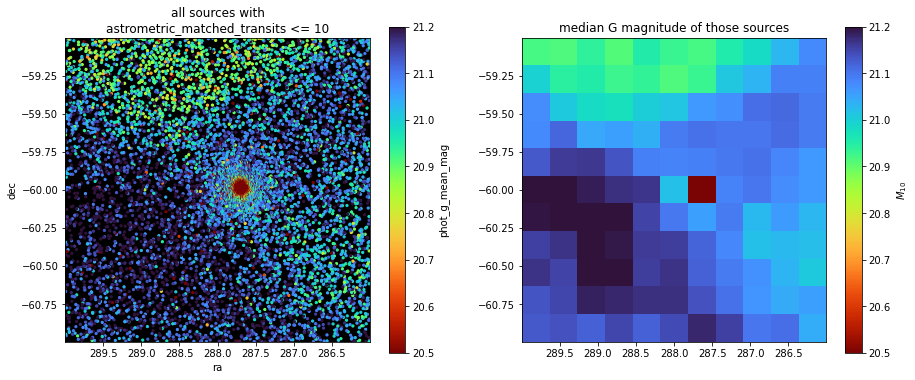

In [11]:
fig=plt.figure(0,figsize=(15,6))
ax=fig.add_subplot(121,aspect=scale)
plt.scatter( GaiaT['ra'] , GaiaT['dec'] , c=GaiaT['phot_g_mean_mag'] , vmin=20.5, vmax=21.2,s=5,cmap='turbo_r')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.colorbar(label='phot_g_mean_mag')
plt.title('all sources with\nastrometric_matched_transits <= 10')
ax.set_facecolor('black')

from scipy import stats
MAPm10, xedges, yedges, binnumber = stats.binned_statistic_2d( GaiaT['ra'], GaiaT['dec'] ,
                                                               GaiaT['phot_g_mean_mag'] ,
                                                               statistic=np.nanmedian, 
                                                               bins = 11 )
ax=fig.add_subplot(122, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, MAPm10.T,cmap='turbo_r', vmin=20.5, vmax=21.2)
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.colorbar(label='$M_{10}$')
plt.title('median G magnitude of those sources')

This map is not a completeness map yet (although $M_{10}$ roughly correlates with the magnitude of 50% completeness). To convert $M_{10}$ to a completeness at a given magnitude, use the function: **m10_to_completeness**.

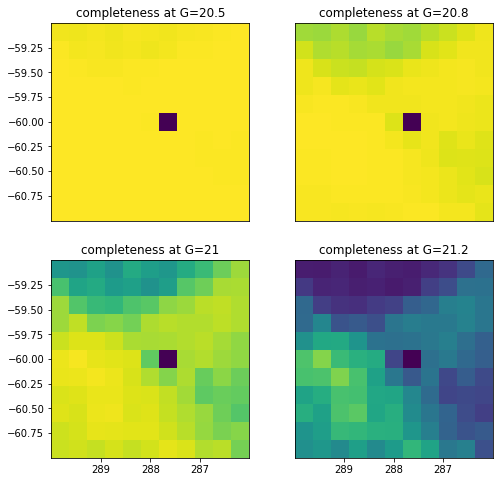

In [12]:
from gaiasf.selectionfunctions import m10_to_completeness

plt.figure(2,figsize=(8,8))

for i,g in enumerate([20.5,20.8,21,21.2]):
    plt.subplot(2,2,i+1,aspect=scale)
    plt.pcolormesh(X, Y, m10_to_completeness(g,MAPm10.T),cmap='viridis',vmin=0,vmax=1)
    plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
    plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
    if i in [0,1]:
        plt.xticks([])
    if i in [1,3]:
        plt.yticks([])
    plt.title(f'completeness at G={g}')

You can also use this to display the completeness as a function of magnitude in all pixels. Areas with values of $M_{10}$ have a higher completeness.

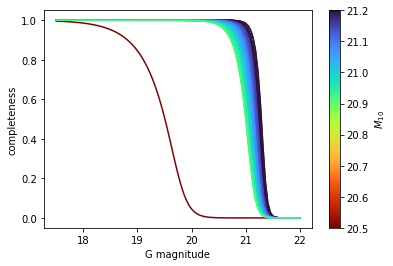

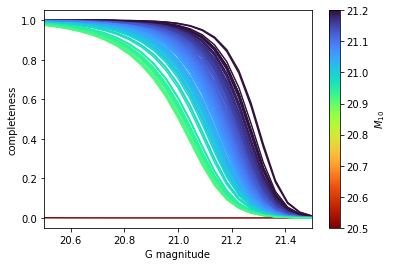

In [13]:
cmap = plt.cm.turbo_r
norm = plt.Normalize(vmin=20.5, vmax=21.2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


gtoplot = np.linspace(17.5,22,100)
plt.figure(3)
for m10 in MAPm10.flatten():
    plt.plot( gtoplot , m10_to_completeness(gtoplot,m10) , color=cmap(norm(m10)))
plt.xlabel('G magnitude')
plt.ylabel('completeness')
plt.colorbar(sm).set_label('$M_{10}$')



plt.figure(4)
for m10 in MAPm10.flatten():
    plt.plot( gtoplot , m10_to_completeness(gtoplot,m10) , color=cmap(norm(m10)))
plt.xlabel('G magnitude')
plt.ylabel('completeness')
plt.xlim(20.5,21.5)
plt.colorbar(sm).set_label('$M_{10}$')



## Accessing the $M_{10}$ maps 

Internally, the maps are stored as numpy arrays of shape (n,3). The first element of each row is the healpix order. For instance, for the all-sky map in healpix order 7 we display at the beginning of this tutorial:

In [14]:
print(dr3sf.m10map)
print(dr3sf.m10map.shape)

[[7.00000e+00 0.00000e+00 2.10278e+01]
 [7.00000e+00 1.00000e+00 2.09157e+01]
 [7.00000e+00 2.00000e+00 2.09398e+01]
 ...
 [7.00000e+00 1.96605e+05 2.09378e+01]
 [7.00000e+00 1.96606e+05 2.11231e+01]
 [7.00000e+00 1.96607e+05 2.10904e+01]]
(196608, 3)


The maps made for patches use healpix order 12:

In [15]:
print(patch.m10map)
print(patch.m10map.shape)

[[1.20000000e+01 1.87430743e+08 2.11331692e+01]
 [1.20000000e+01 1.87430747e+08 2.11331692e+01]
 [1.20000000e+01 1.87430748e+08 2.11331692e+01]
 ...
 [1.20000000e+01 1.93210928e+08 2.09576740e+01]
 [1.20000000e+01 1.93210944e+08 2.09393578e+01]
 [1.20000000e+01 1.93211008e+08 2.09393578e+01]]
(19507, 3)


In [16]:
print(patch_higher_res.m10map)
print(patch_higher_res.m10map.shape)

[[1.20000000e+01 1.87430743e+08 2.11297150e+01]
 [1.20000000e+01 1.87430747e+08 2.11297150e+01]
 [1.20000000e+01 1.87430748e+08 2.11297150e+01]
 ...
 [1.20000000e+01 1.93210928e+08 2.09576740e+01]
 [1.20000000e+01 1.93210944e+08 2.09393578e+01]
 [1.20000000e+01 1.93211008e+08 2.09393578e+01]]
(19507, 3)


In [17]:
print('The patch map contains %i NaNs.' % (np.count_nonzero(np.isnan(patch.m10map))))
print('The higher-resolution patch map contains %i NaNs.' % (np.count_nonzero(np.isnan(patch.m10map))))

The patch map contains 354 NaNs.
The higher-resolution patch map contains 354 NaNs.


# Example of a custom-made adaptive binning with square bins

Here we query the Gaia archive and make $M_{10}$ maps of increasing resolution.

In [18]:
ra = 288
dec = -60
size = 4 #size of the square field of view, in degree
resMax = 0.002 #minimum bin size in degree
min_points = 10 #minimum number of points per bin

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
	
scale=1./np.cos(np.radians(dec))
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited
queryStringGaia = """SELECT ra, dec, phot_g_mean_mag
	FROM gaiadr3.gaia_source 
	WHERE ra>%.3f and ra<%.3f
	and dec>%.3f and dec<%.3f
	and phot_g_mean_mag<50
	and astrometric_matched_transits<11""" % (ra-scale*size/2,ra+scale*size/2,dec-size/2,dec+size/2)
job = Gaia.launch_job_async(queryStringGaia)
GaiaT = job.get_results()
print( f'{len(GaiaT)} sources downloaded.')

INFO: Query finished. [astroquery.utils.tap.core]
38485 sources downloaded.


In [19]:
import warnings
allHcounts = []
allHmedians = []

N=0
while size/2**N > resMax:
	print('Iteration',N,'bin size is',size/2**N)
	
	#we first count the sources so we can evaluate if our bins are too small:
	H, xedges, yedges = np.histogram2d(GaiaT['ra'], GaiaT['dec'], bins=2**N)
	#Then compute the median.
	#We anticipate a lot of empty bins, for which np.nanmedian will return a RuntimeWarning
	#so we catch those and don't print them to screen.
	with warnings.catch_warnings():
		warnings.simplefilter("ignore", category=RuntimeWarning)
		MAPm10, xedges, yedges, binnumber = stats.binned_statistic_2d( GaiaT['ra'], GaiaT['dec'] ,
	                                                                   GaiaT['phot_g_mean_mag'] ,
	                                                                   statistic=np.nanmedian, 
	                                                                   bins = 2**N )
                                                                   
	MAPm10[H<min_points]=np.nan
	allHcounts.append( H )
	allHmedians.append( MAPm10 )
	
	N=N+1

#we use the highest available resolution:
finalMap = allHmedians[-1]
#we go through this map and find all empty pixels:
nbRows = len(finalMap)
nbCols = len(finalMap[0])

stepUp=1
while np.isnan(finalMap).any():
	print('Going up one level...',stepUp)
	for j in range(nbRows):
		for i in range(nbCols):
			if np.isnan(finalMap[j][i]):
				#print('replacing',finalMap[j][i],'with',allHmedians[-2][i//2][j//2])
				finalMap[j][i] = allHmedians[-1-1*stepUp][j//2**stepUp][i//2**stepUp]
	stepUp=stepUp+1
		
	
print('...done')

Iteration 0 bin size is 4.0
Iteration 1 bin size is 2.0
Iteration 2 bin size is 1.0
Iteration 3 bin size is 0.5
Iteration 4 bin size is 0.25
Iteration 5 bin size is 0.125
Iteration 6 bin size is 0.0625
Iteration 7 bin size is 0.03125
Iteration 8 bin size is 0.015625
Iteration 9 bin size is 0.0078125
Iteration 10 bin size is 0.00390625
Going up one level... 1
Going up one level... 2
Going up one level... 3
Going up one level... 4
Going up one level... 5
...done


We can now convert the $M_{10}$ map to a completeness map at any magnitude.

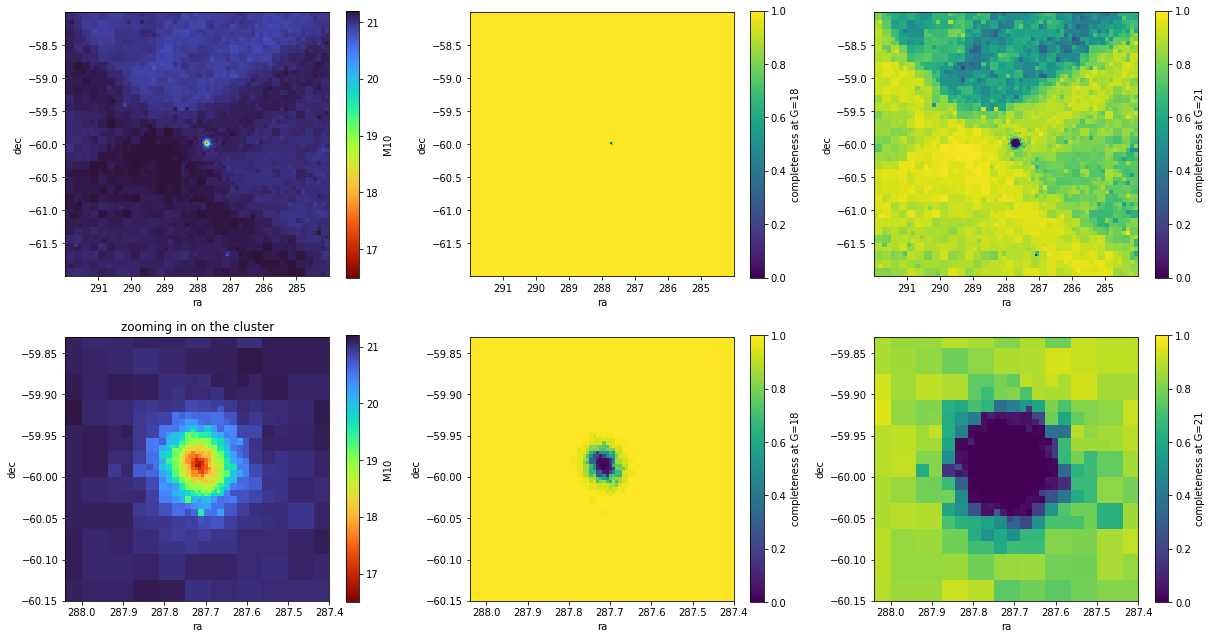

In [20]:
from gaiasf.selectionfunctions import m10_to_completeness

fig = plt.figure(figsize=(17,9))

ax=fig.add_subplot(231, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, finalMap.T,cmap='turbo_r',vmin=16.5,vmax=21.2)
plt.colorbar(label='M10')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(232, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(18,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=18')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(233, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(21,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=21')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(234, aspect=scale)
plt.title('zooming in on the cluster')
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, finalMap.T,cmap='turbo_r',vmin=16.5,vmax=21.2)
plt.colorbar(label='M10')
plt.xlim(288.04,287.40)
plt.ylim(-60.15,-59.83)
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(235, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(18,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=18')
plt.xlim(288.04,287.40)
plt.ylim(-60.15,-59.83)
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(236, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(21,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=21')
plt.xlim(288.04,287.40)
plt.ylim(-60.15,-59.83)
plt.xlabel('ra'); plt.ylabel('dec')

plt.tight_layout()

# Interactive map

**Note: the map will only be interactive if you run the notebook locally, not in the online (static) version.**

This makes a zoomable map with a slider to change the magnitude.

The underlying **MAPm10** is a 1024 x 1024 array, so updating the figure is slow.

<IPython.core.display.Javascript object>


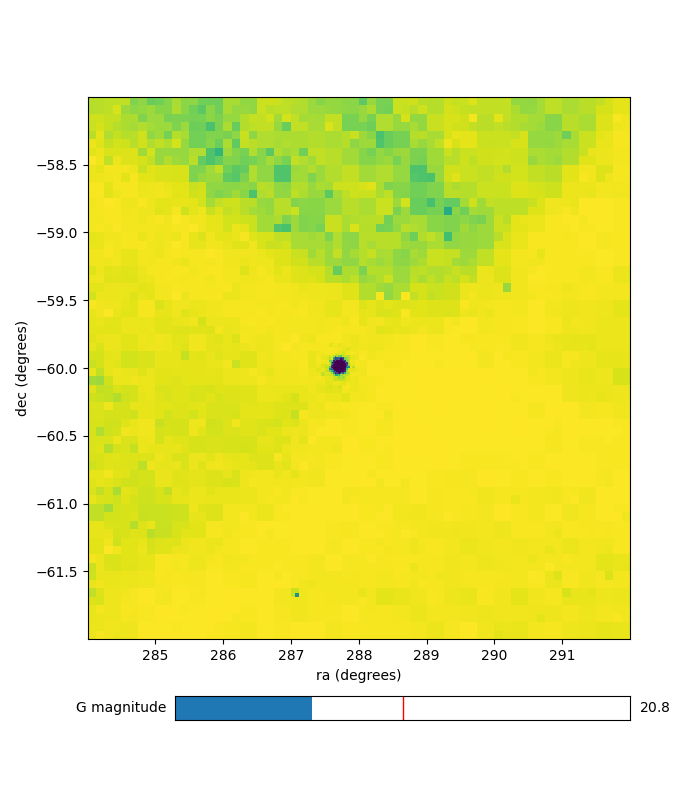

0

In [21]:
%matplotlib notebook
from matplotlib.widgets import Slider

fig=plt.figure(figsize=(7,8))
ax=plt.subplot(111,aspect=scale)
cMap = ax.pcolormesh(X, Y, m10_to_completeness(21,MAPm10.T),cmap='viridis',vmin=0,vmax=1)
plt.xlabel('ra (degrees)')
plt.ylabel('dec (degrees)')

plt.subplots_adjust(bottom=0.2)
ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_Gmag = Slider(ax_slider,"G magnitude",valmin=20.5,valmax=21.5,valinit=21,valstep=0.1)

def update(val):
    current_G = slider_Gmag.val
    newCompletenessMap = m10_to_completeness(current_G,MAPm10.T)
    print(current_G)
    ax.pcolormesh(X, Y, newCompletenessMap,cmap='viridis',vmin=0,vmax=1)
    fig.canvas.draw()
    
slider_Gmag.on_changed(update)